### Import Required Libraries

In [1]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import zipfile
import random
import shutil
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

print(f"Keras version: {keras.__version__}")
print(f"Using backend: {keras.backend.backend()}")

Keras version: 3.10.0
Using backend: torch


### Step 1: Load the MRI Image Dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Paths to folders
train_dir = '/content/drive/MyDrive/Colab Notebooks/Training'
test_dir = '/content/drive/MyDrive/Colab Notebooks/Testing'

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
target_size = (224, 224)  # resize all images to 224x224

def load_images_from_folder(folder_path, classes, target_size):
    images = []
    labels = []
    for idx, class_name in enumerate(classes):
        class_folder = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            try:
                img = Image.open(img_path).convert('RGB')
                img = img.resize(target_size)
                images.append(np.array(img))
                labels.append(idx)
            except Exception as e:
                print(f"Failed to load {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load training images
X_train, y_train = load_images_from_folder(train_dir, classes, target_size)

# Load testing images
X_test, y_test = load_images_from_folder(test_dir, classes, target_size)

print(f"Train images: {X_train.shape}, Train labels: {y_train.shape}")
print(f"Test images: {X_test.shape}, Test labels: {y_test.shape}")


Train images: (5712, 224, 224, 3), Train labels: (5712,)
Test images: (1311, 224, 224, 3), Test labels: (1311,)


### Dataset Overview


In [4]:
# Class names
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Count occurrences in training set
train_counts = [np.sum(y_train == i) for i in range(len(classes))]
test_counts  = [np.sum(y_test == i) for i in range(len(classes))]

# Display
print("Training set class distribution:")
for class_name, count in zip(classes, train_counts):
    print(f"{class_name}: {count} images")

print("\nTesting set class distribution:")
for class_name, count in zip(classes, test_counts):
    print(f"{class_name}: {count} images")


Training set class distribution:
glioma: 1321 images
meningioma: 1339 images
notumor: 1595 images
pituitary: 1457 images

Testing set class distribution:
glioma: 300 images
meningioma: 306 images
notumor: 405 images
pituitary: 300 images


### Visual Exploration

Display **5 random sample images** from each of the 4 classes to get a sense of the dataset's diversity:

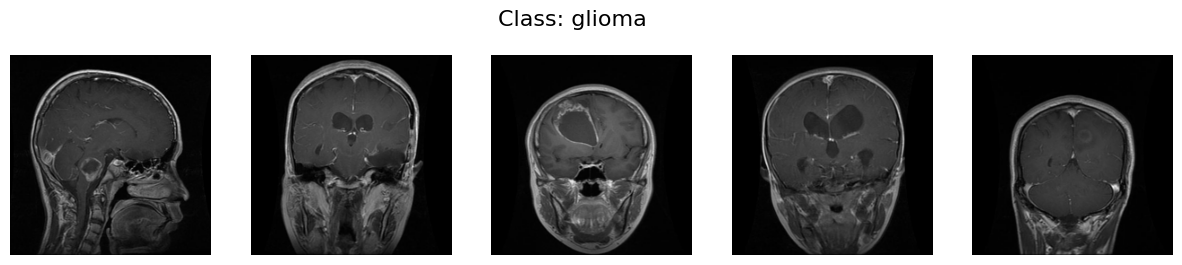

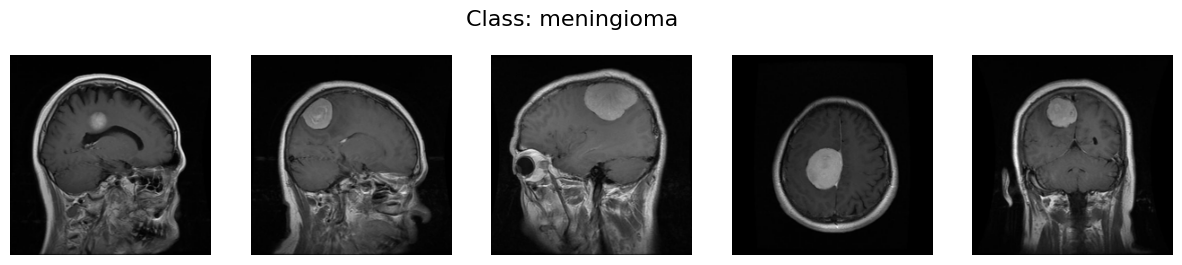

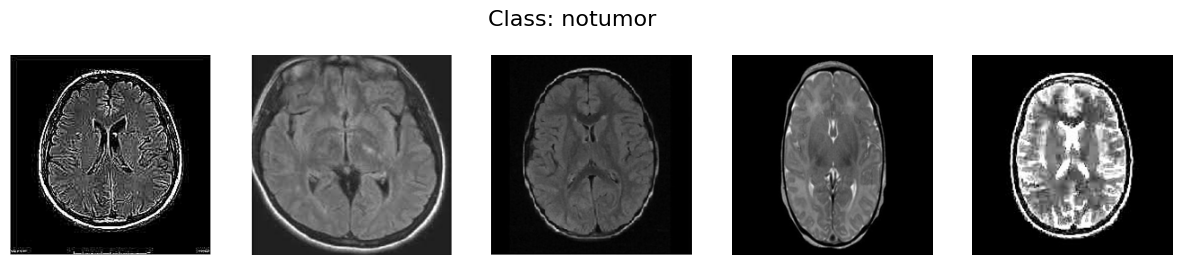

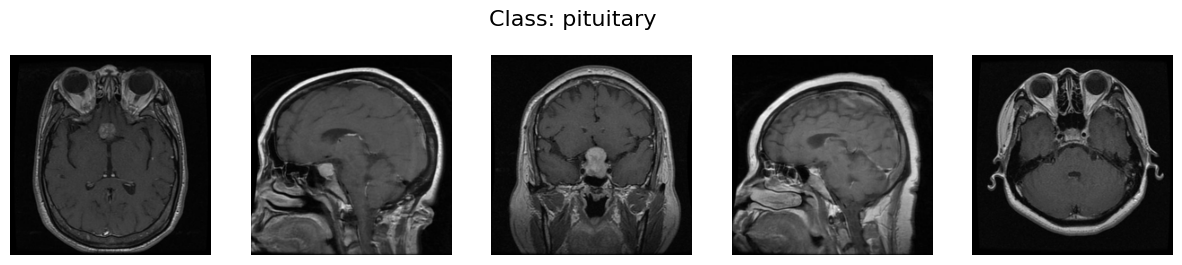

In [5]:
# Set random seed for reproducibility
np.random.seed(42)

# Loop over classes
for class_idx, class_name in enumerate(classes):
    # Get indices of all images belonging to this class
    class_indices = np.where(y_train == class_idx)[0]

    # Randomly choose 5 indices
    sample_indices = np.random.choice(class_indices, size=5, replace=False)

    # Plot the samples
    plt.figure(figsize=(15,3))
    plt.suptitle(f"Class: {class_name}", fontsize=16)

    for i, idx in enumerate(sample_indices):
        plt.subplot(1, 5, i+1)
        plt.imshow(X_train[idx])
        plt.axis('off')

    plt.show()

## Step 2: Split Dataset into Training, Validation, and Test Sets

In [6]:
from sklearn.model_selection import train_test_split

# Split training images into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.1,       # 10% validation
    random_state=42,     # reproducibility
    stratify=y_train     # keeps class balance
)

## Step 3: Create Data Generators with Augmentation

In [7]:
def train_val_generators(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    Creates the training, validation, and test data generators
    for manually loaded NumPy arrays.

    Args:
      X_train, y_train: training images and labels
      X_val, y_val: validation images and labels
      X_test, y_test: testing images and labels

    Returns:
      train_generator, validation_generator, test_generator
    """

    # Training generator with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Validation/test generator (no augmentation)
    val_test_datagen = ImageDataGenerator(rescale=1./255)

    # Use .flow() for NUMPY arrays
    train_generator = train_datagen.flow(
        X_train, y_train,
        batch_size=32,
        shuffle=True
    )

    validation_generator = val_test_datagen.flow(
        X_val, y_val,
        batch_size=32,
        shuffle=False
    )

    test_generator = val_test_datagen.flow(
        X_test, y_test,
        batch_size=32,
        shuffle=False
    )

    return train_generator, validation_generator, test_generator

In [8]:
# Test your generators
train_generator, validation_generator, test_generator = train_val_generators(X_train_split, y_train_split, X_val, y_val, X_test, y_test)

## CNN Architecture

In [14]:
def create_model():
  model = keras.models.Sequential([

    # start building the model here
    # Block 1
    keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    keras.layers.MaxPooling2D((2,2)),

    # Block 2
    keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2,2)),

    # Block 3
    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2,2)),

    # Block 4
    keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    keras.layers.MaxPooling2D((2,2)),

    # Flatten and Dense layers
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),

    # Output layer
    keras.layers.Dense(10, activation='softmax')


    # end building the model here
  ])


  # Compile with appropriate loss for multi-class classification
  model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

  return model

In [15]:
# create the untrained model
model = create_model()

# Display model architecture
model.summary()

# Count parameters
total_params = model.count_params()
print(f"Total parameters in the model: {total_params}")

# Train the model
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=validation_generator,
    verbose=1
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,091,530 (49.94 MB)

 Trainable params: 13,091,530 (49.94 MB)

 Non-trainable params: 0 (0.00 B)

Total parameters in the model: 13091530
Epoch 1/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 73s 452ms/step - accuracy: 0.4499 - loss: 1.2609 - val_accuracy: 0.5699 - val_loss: 1.1070
Epoch 2/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 70s 433ms/step - accuracy: 0.6618 - loss: 0.8063 - val_accuracy: 0.7500 - val_loss: 0.6789
Epoch 3/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 70s 433ms/step - accuracy: 0.6961 - loss: 0.7272 - val_accuracy: 0.7622 - val_loss: 0.6017
Epoch 4/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 71s 438ms/step - accuracy: 0.7474 - loss: 0.6276 - val_accuracy: 0.7203 - val_loss: 0.7365
Epoch 5/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 69s 431ms/step - accuracy: 0.7503 - loss: 0.6161 - val_accuracy: 0.8374 - val_loss: 0.4778
Epoch 6/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 69s 430ms/step - accuracy: 0.7915 - loss: 0.5395 - val_accuracy: 0.7920 - val_loss: 0.5554
Epoch 7/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 70s 436ms/step - accuracy: 0.7999 - loss: 0.4926 - val_accuracy: 0.7605 - val_loss: 0.6669
Epoch 8/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 69s

### Visualize Training Progress

Once training has finished, visualize the **training and validation metrics** across epochs.



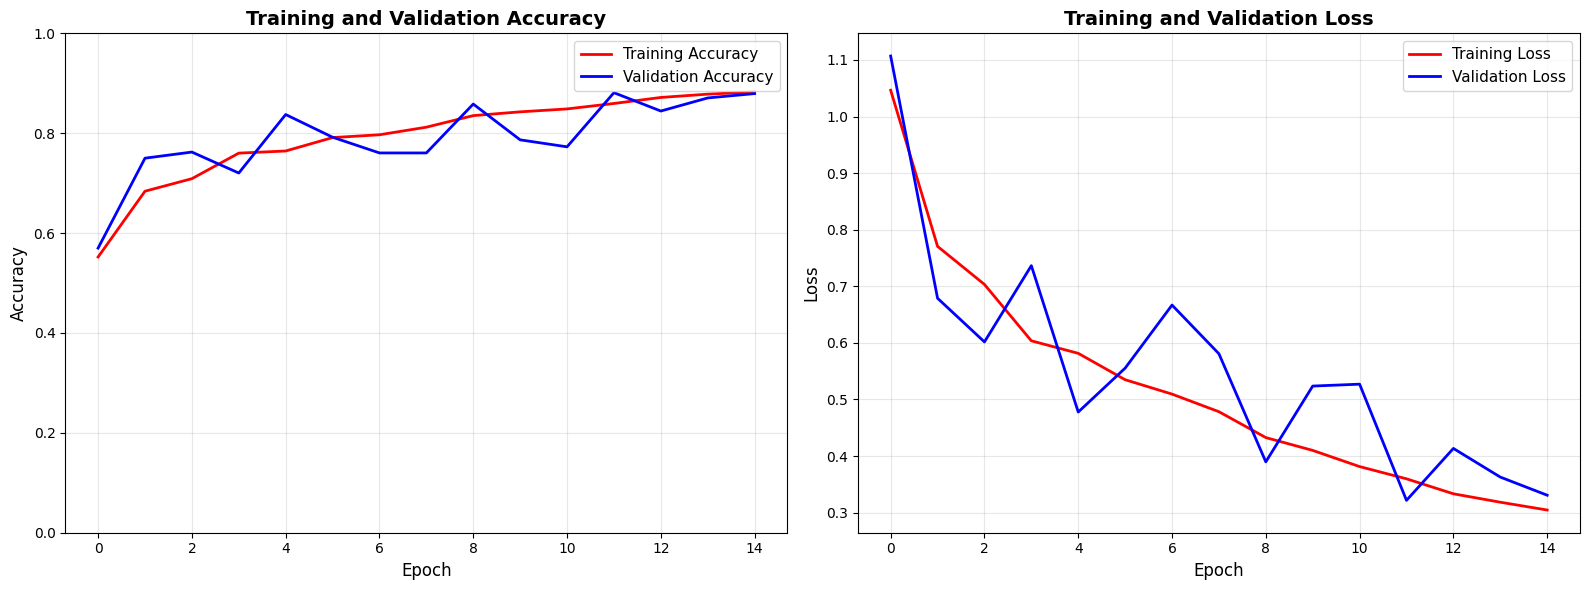


  Training Summary
  Best Training Accuracy:   0.8827 (epoch 15)
  Best Validation Accuracy: 0.8811 (epoch 12)
  Final Training Accuracy:  0.8827
  Final Validation Accuracy:0.8794
  Accuracy Gap (final):     0.0033


In [16]:
# Extract training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Accuracy
ax1.plot(epochs_range, acc, 'r-', linewidth=2, label="Training Accuracy")
ax1.plot(epochs_range, val_acc, 'b-', linewidth=2, label="Validation Accuracy")
ax1.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: Loss
ax2.plot(epochs_range, loss, 'r-', linewidth=2, label="Training Loss")
ax2.plot(epochs_range, val_loss, 'b-', linewidth=2, label="Validation Loss")
ax2.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*60}")
print(f"  Training Summary")
print(f"{'='*60}")
print(f"  Best Training Accuracy:   {max(acc):.4f} (epoch {acc.index(max(acc))+1})")
print(f"  Best Validation Accuracy: {max(val_acc):.4f} (epoch {val_acc.index(max(val_acc))+1})")
print(f"  Final Training Accuracy:  {acc[-1]:.4f}")
print(f"  Final Validation Accuracy:{val_acc[-1]:.4f}")
print(f"  Accuracy Gap (final):     {abs(acc[-1] - val_acc[-1]):.4f}")
print(f"{'='*60}")

In [17]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.8032 - loss: 0.4621
Test accuracy: 0.8635
